In [1]:
from collections import Counter
import nltk
import re
from nltk.corpus import stopwords
from time import time
from timeit import timeit
import pickle
import pandas as pd
import numpy as np
import json

from inverted_index_gcp import *

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
!pip install -q google-cloud-storage==1.43.0

In [3]:
# authenticate below for Google Storage access as needed
from google.colab import auth
auth.authenticate_user()

In [4]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [46]:
def get_docs_binary(queries_to_search, index, file_name, expand=False):
    ids_and_words = {}
    for term in np.unique(tokenize(queries_to_search, expand)):
        if term in index.df.keys():
            list_of_doc = read_posting_list(index, term, file_name)
            for doc_id, _ in list_of_doc:
                if doc_id in ids_and_words:
                    ids_and_words[doc_id] += 1
                else:
                    ids_and_words[doc_id] = 1
    return sorted(ids_and_words, key=ids_and_words.get, reverse=True)


def read_posting_list(inverted, w, file_name):
    posting_list = []
    with closing(MultiFileReader()) as reader:
        if w in inverted.df:
            locs = inverted.posting_locs[w]
            locs = [(file_name + lo[0], lo[1]) for lo in locs]
            b = reader.read(locs, inverted.df[w] * TUPLE_SIZE)
            for i in range(inverted.df[w]):
                doc_id = int.from_bytes(b[i * TUPLE_SIZE:i * TUPLE_SIZE + 4], 'big')
                tf = int.from_bytes(b[i * TUPLE_SIZE + 4:(i + 1) * TUPLE_SIZE], 'big')
                posting_list.append((doc_id, tf))
    return posting_list


def tokenize(text, expand=False):
    english_stopwords = frozenset(stopwords.words('english'))
    corpus_stopwords = ["category", "references", "also", "external", "links",
                        "may", "first", "see", "history", "people", "one", "two",
                        "part", "thumb", "including", "second", "following",
                        "many", "however", "would", "became", 'make']
    RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)
    all_stopwords = english_stopwords.union(corpus_stopwords)

    list_of_tokens = [token.group() for token in RE_WORD.finditer(text.lower()) if
                      token.group() not in all_stopwords]
    if expand:
        list_of_tokens = expand_query(list_of_tokens)
    return list_of_tokens

def expand_query(query_tokens):
    new_tokens = []
    for tok in query_tokens:
        sim = model.most_similar(tok, topn=5)
        for word in sim:
            new_tokens.append(word[0])
        new_tokens.append(tok)
    return new_tokens

def tfidf_func(query, inverted, file_name):
    query_tfidf = {}
    doc_tfidf = defaultdict(list)
    numerator = {}
    cos = {}
    query_tokens = tokenize(query)
    for token in query_tokens:
        post_list = read_posting_list(inverted, token, file_name)
        idf = np.log2(len(id_lengths_dict) / (inverted.df[token] + 1))
        query_tfidf[token] = query_tokens.count(token) / len(query_tokens)
        for doc_id, freq in post_list:
            if doc_id == 0:
                continue
            doc_tfidf[token].append((doc_id, freq * idf / id_lengths_dict[str(doc_id)]))
    
    for key, val in doc_tfidf.items():
        for doc_id, tfidf in val:
            if doc_id in numerator:
                numerator[doc_id] += tfidf * query_tfidf[key]
            else:
                numerator[doc_id] = tfidf * query_tfidf[key]

    for key, val in numerator.items():
        cos[key] = val / (id_lengths_dict[str(key)] * len(query_tokens))

    return sorted(cos, key=cos.get, reverse=True)


def sim(query_tokens):
    similarity = []
    final = []
    for i, w1 in enumerate(query_tokens):
        for j, w2 in enumerate(query_tokens):
            if i != j and w1 in model and w2 in model:
                similarity.append((w1, w2, model.similarity(w1, w2)))
    for i in similarity:
        if i[2] >= 0.39:
            final.append(i[0])
            final.append(i[1])
    if final:
        return True, ' '.join(final)
    return False, ' '.join(query_tokens)
def search2(query):
    query_tokens = tokenize(query)
    if len(query_tokens) == 1:
        ans = get_docs_binary(query, inverted_title, loc_title)[:100]
    else:
        sign, new_query = sim(tokenize(query))
        if sign:
            ans = get_docs_binary(new_query, inverted_title, loc_title)[:100]
        elif len(query_tokens) == 2:
            ans = get_docs_binary(query, inverted_title, loc_title)[:100]           
        else:
            ans = get_docs_binary(query, inverted_text, loc_text, True)[:100]
    res = [(id, id_title_dict[id]) for id in ans]
    return res
def search1(query):
    ans = get_docs_binary(query, inverted_title, loc_title)[:100]
    res = [(id, id_title_dict[id]) for id in ans]
    return res

def search(query):
    page_view = {}
    ids_text = set(tfidf_func(query, inverted_text, loc_text))
    ids_title = set(get_docs_binary(query, inverted_title, loc_title))
    ids_anchor = set(get_docs_binary(query, inverted_anchor, loc_anchor))

    intersection_ids = list(ids_text&ids_title&ids_anchor)
    if intersection_ids:
        for id in intersection_ids:
            page_view[id] = pw[id]

        page_view_sorted = sorted(page_view, key=page_view.get, reverse=True)[:100]
        res = [(id, id_title_dict[id]) for id in page_view_sorted]
    return res

In [6]:
inverted_text = InvertedIndex.read_index("/content/gdrive/MyDrive/IR_Project_Data/postings_gcp_text", 'index')
inverted_title = InvertedIndex.read_index("/content/gdrive/MyDrive/IR_Project_Data/postings_gcp_title", 'index')
inverted_anchor = InvertedIndex.read_index("/content/gdrive/MyDrive/IR_Project_Data/postings_gcp_anchor", 'index')

loc_text = "/content/gdrive/MyDrive/IR_Project_Data/postings_gcp_text/"
loc_title = "/content/gdrive/MyDrive/IR_Project_Data/postings_gcp_title/"
loc_anchor = "/content/gdrive/MyDrive/IR_Project_Data/postings_gcp_anchor/"

id_title_dict = pd.read_pickle("/content/gdrive/MyDrive/IR_Project_Data/id_title_dict.pickle")
with open("/content/gdrive/MyDrive/IR_Project_Data/doc_lengths.json") as f:
    id_lengths_dict = json.load(f)
with open("/content/gdrive/MyDrive/IR_Project_Data/page_rank_data.json") as f:
    pr = json.load(f)
pw = pd.read_pickle("/content/gdrive/MyDrive/IR_Project_Data/pageviews.pkl")

In [7]:
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("/content/gdrive/MyDrive/IR_Project_Data/wiki-news-300d-1M.vec")

In [ ]:
search("NBA")

TESTTT

In [ ]:
qs_res

In [51]:
qs_res = []
qs_res1 = []
qs_res2 = []

In [52]:
for q, true_wids in queries.items():
    duration, ap = None, None
    t_start = time()

    res = search(q)
    duration = time() - t_start
    t_start = time()
    
    res1 = search1(q)
    duration1 = time() - t_start
    t_start = time()

    res2 = search2(q)
    duration2 = time() - t_start
#  if res.status_code == 200:
    pred_wids, _ = zip(*res)
    pred_wids1, _ = zip(*res1)
    pred_wids2, _ = zip(*res2)
    ap = average_precision(true_wids, pred_wids)
    ap1 = average_precision(true_wids, pred_wids1)
    ap2 = average_precision(true_wids, pred_wids2)
    
    qs_res.append((q, duration, ap))
    qs_res1.append((q, duration1, ap1))
    qs_res2.append((q, duration2, ap2))


In [53]:
avg_score = []
avg_score.append(sum([i[2] for i in qs_res]) / len(qs_res))
avg_score.append(sum([i[2] for i in qs_res1]) / len(qs_res1))
avg_score.append(sum([i[2] for i in qs_res2]) / len(qs_res2))
print(avg_score)

[0.4291333333333333, 0.4890333333333334, 0.5191333333333332]


In [54]:
avg_time = []
avg_time.append(sum([i[1] for i in qs_res]) / len(qs_res))
avg_time.append(sum([i[1] for i in qs_res1]) / len(qs_res1))
avg_time.append(sum([i[1] for i in qs_res2]) / len(qs_res2))
print(avg_time)

[2.1349905172983807, 0.008306153615315755, 0.7611847877502441]


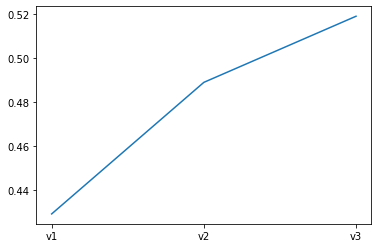

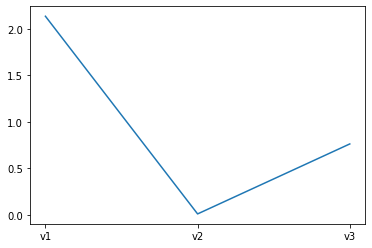

In [63]:
import matplotlib.pyplot as plt

versions = ['v1', 'v2', 'v3']
plt.plot(versions, avg_score)
plt.show()
plt.plot(versions, avg_time)
plt.show()

In [23]:
for i, j, k in qs_res:
    print(i, k)

python 0.735
data science 0.636
migraine 1.0
chocolate 0.491
how to make pasta 0.248
Does pasta have preservatives? 0.071
how google works 0.559
what is information retrieval 0.951
NBA 0.51
yoga 0.848
how to not kill plants 0.0
masks 0.513
black friday 0.886
why do men have nipples 0.0
rubber duck 0.841
michelin 0.49
what to watch 0.229
best marvel movie 0.094
how tall is the eiffel tower 0.656
where does vanilla flavoring come from 0.325
best ice cream flavour 0.729
how to tie a tie 0.483
how to earn money online 0.053
what is critical race theory 0.53
what space movie was made in 1992 0.143
how to vote 0.455
google trends 0.777
dim sum 0.884
ted 0.847
fairy tale 0.59


In [24]:
print(f'avg: {sum([i[2] for i in qs_res]) / len(qs_res)}')
print(f'time: {sum([i[1] for i in qs_res]) / len(qs_res)}')

avg: 0.5191333333333332
time: 0.7245623032251994


In [11]:
import json

with open('queries_train.json', 'rt') as f:
  queries = json.load(f)

In [21]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [60]:
import requests
from time import time
# url = 'http://35.232.59.3:8080'
# place the domain you got from ngrok or GCP IP below. 
url = 'http://35.188.202.53:8080' #'http://XXXX-XX-XX-XX-XX.ngrok.io'

qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search_title', {'query': q}, timeout=35)
    #print(res.content)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

In [61]:
qs_res

[('python', 0.09058260917663574, 0.735),
 ('data science', 0.3163611888885498, 0.636),
 ('migraine', 0.08284878730773926, 1.0),
 ('chocolate', 0.1253979206085205, 0.491),
 ('how to make pasta', 0.08222436904907227, 0.248),
 ('Does pasta have preservatives?', 0.0829782485961914, 0.071),
 ('how google works', 0.18004179000854492, 0.559),
 ('what is information retrieval', 0.22011137008666992, 0.951),
 ('NBA', 0.1266922950744629, 0.51),
 ('yoga', 0.08422470092773438, 0.848),
 ('how to not kill plants', 0.1702895164489746, 0.0),
 ('masks', 0.0819239616394043, 0.513),
 ('black friday', 0.3167548179626465, 0.886),
 ('why do men have nipples', 0.1758127212524414, 0.0),
 ('rubber duck', 0.1272423267364502, 0.841),
 ('michelin', 0.08225059509277344, 0.49),
 ('what to watch', 0.12491869926452637, 0.229),
 ('best marvel movie', 0.38164663314819336, 0.0),
 ('how tall is the eiffel tower', 0.22690057754516602, 0.656),
 ('where does vanilla flavoring come from', 0.18697762489318848, 0.0),
 ('best ic

In [62]:
print(f'avg: {sum([i[2] for i in qs_res]) / len(qs_res)}')
print(f'time: {sum([i[1] for i in qs_res]) / len(qs_res)}')

avg: 0.4890333333333334
time: 0.17245912551879883
